# Bruise Detection using Simple CNN

This notebook implements a basic CNN architecture for binary bruise detection (bruise vs normal skin).

In [1]:
%pip install tensorflow numpy matplotlib pillow scikit-learn seaborn

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


## Data Loading and Preprocessing

In [2]:
def load_binary_data(data_dir='dataset/Wound_dataset copy', img_size=(224, 224)):
    images = []
    labels = []
    
    # Process bruise images (positive class)
    bruise_path = os.path.join(data_dir, 'Bruises')
    if os.path.exists(bruise_path):
        for img_name in os.listdir(bruise_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(bruise_path, img_name)
                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
                    labels.append(1)  # 1 for bruise
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    # Process normal skin images (negative class)
    normal_path = os.path.join(data_dir, 'Normal')
    if os.path.exists(normal_path):
        for img_name in os.listdir(normal_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(normal_path, img_name)
                try:
                    img = Image.open(img_path)
                    img = img.convert('RGB')
                    img = img.resize(img_size)
                    img_array = np.array(img) / 255.0
                    images.append(img_array)
                    labels.append(0)  # 0 for normal
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

def create_augmented_dataset(images, labels, batch_size=32):
    # Create dataset from numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    # Define augmentation function
    def augment(image, label):
        # Random choice between original, flip, or rotation
        choice = tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32)
        
        def apply_flip():
            return tf.image.flip_left_right(image), label
        
        def apply_rotation():
            # Rotate by 20 degrees
            angle = tf.constant(20, dtype=tf.float32)
            radian = angle * 3.14159 / 180
            return tf.image.rot90(image, k=tf.cast(radian / (3.14159/2), tf.int32)), label
        
        def keep_original():
            return image, label
        
        result = tf.case([(tf.equal(choice, 1), apply_flip),
                         (tf.equal(choice, 2), apply_rotation)],
                        default=keep_original)
        return result
    
    # Apply augmentation and create batches
    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def create_simple_model(input_shape):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Simple CNN architecture
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.01),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.01),

        layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        layers.Flatten(),
        
        # Dense layer
        layers.Dense(64, activation='relu'),
        layers.LeakyReLU(alpha=0.01),
        layers.Dropout(0.5),  # Dropout for regularization
        
        # Output layer (binary classification)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [3]:
# Load the data
X, y = load_binary_data()

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)

# Create augmented datasets
train_dataset = create_augmented_dataset(X_train, y_train, batch_size=32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

print("\nData split sizes:")
print(f"Training set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

# Create and compile the model
input_shape = X_train[0].shape
model = create_simple_model(input_shape)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

model.summary()


Data split sizes:
Training set: 317 images
Validation set: 80 images
Test set: 45 images


C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 802816)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      51,380,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,399,745 (196.07 MB)

 Trainable params: 51,399,745 (196.07 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Train the model using the augmented dataset
history = model.fit(
    train_dataset,  # Using the augmented dataset for training
    epochs=10,
    validation_data=val_dataset,
    verbose=1
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 73s 7s/step - Precision: 0.5469 - Recall: 0.5271 - accuracy: 0.5245 - loss: 14.5040 - val_Precision: 0.9200 - val_Recall: 0.5227 - val_accuracy: 0.7125 - val_loss: 0.5456
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - Precision: 0.7915 - Recall: 0.6910 - accuracy: 0.7247 - loss: 0.6558 - val_Precision: 0.9444 - val_Recall: 0.7727 - val_accuracy: 0.8500 - val_loss: 0.3550
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - Precision: 0.9108 - Recall: 0.7761 - accuracy: 0.8326 - loss: 0.4093 - val_Precision: 0.9167 - val_Recall: 0.7500 - val_accuracy: 0.8250 - val_loss: 0.3717
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - Precision: 0.9233 - Recall: 0.8011 - accuracy: 0.8511 - loss: 0.3505 - val_Precision: 0.9091 - val_Recall: 0.9091 - val_accuracy: 0.9000 - val_loss: 0.2971
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - Precision: 0.9323 - Recall: 0.8706 - accuracy: 0.8889 - loss: 0.2780 - val_Precision: 1.0000 - val_Recall: 0.4318 -

## Model Evaluation and Analysis

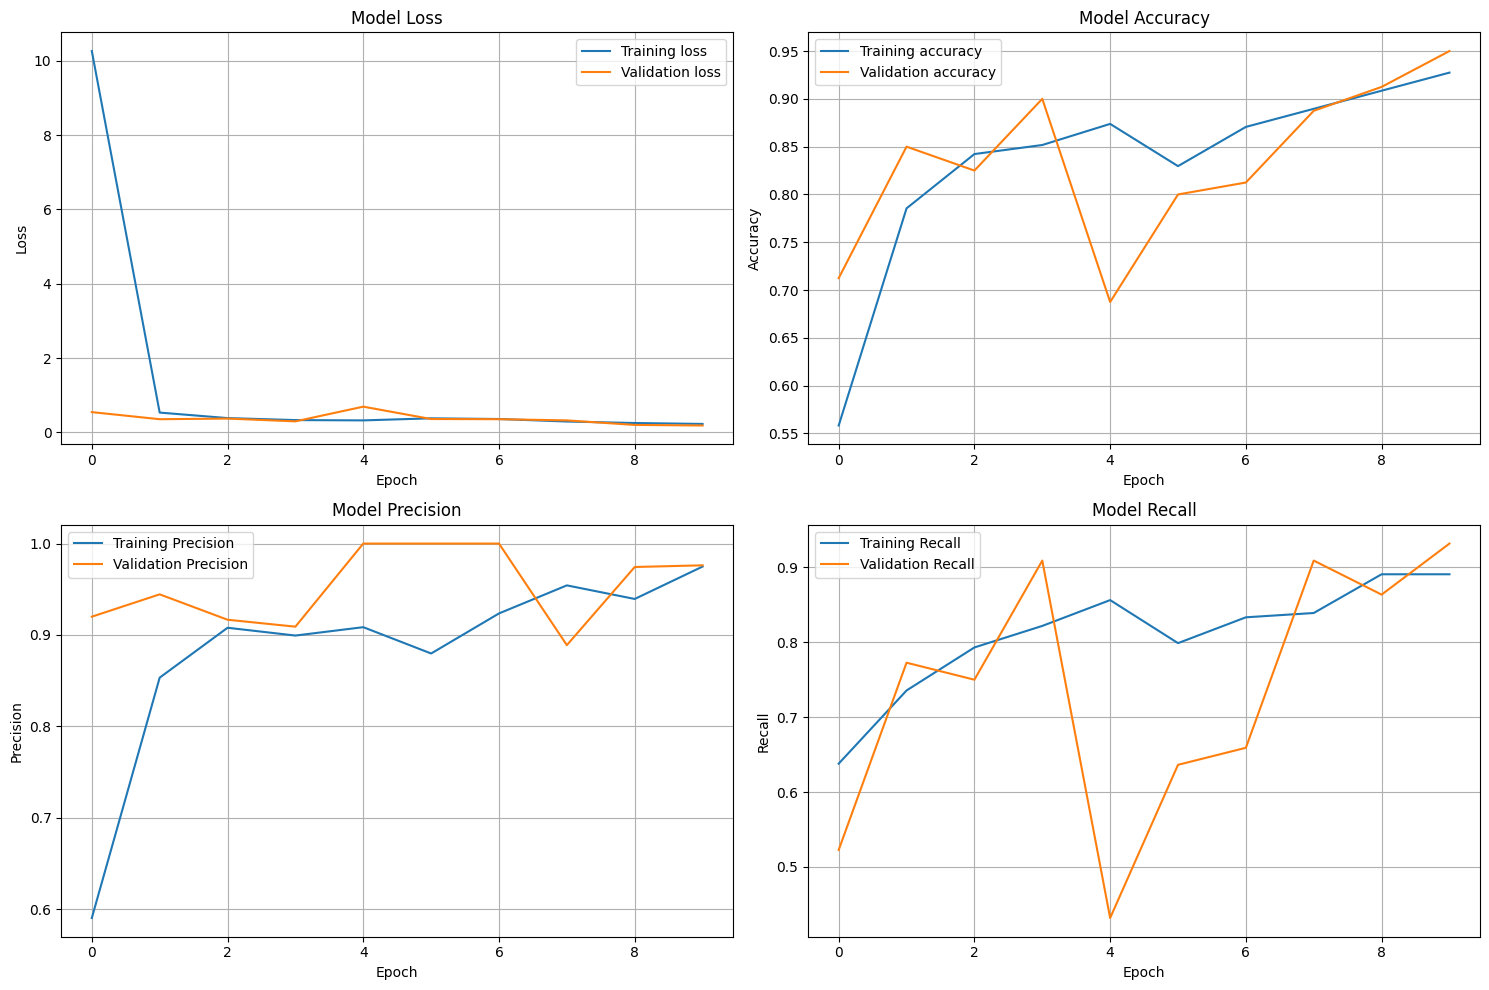

In [5]:
def plot_training_history(history):
    metrics = ['loss', 'accuracy', 'Precision', 'Recall']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for idx, metric in enumerate(metrics):
        row = idx // 2
        col = idx % 2
        
        axes[row, col].plot(history.history[metric], label=f'Training {metric}')
        axes[row, col].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[row, col].set_title(f'Model {metric.capitalize()}')
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(metric.capitalize())
        axes[row, col].legend()
        axes[row, col].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


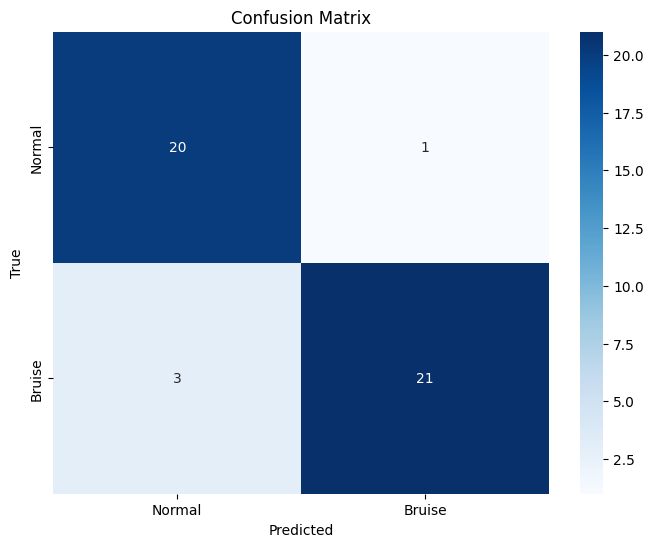


Classification Report:
              precision    recall  f1-score   support

      Normal       0.87      0.95      0.91        21
      Bruise       0.95      0.88      0.91        24

    accuracy                           0.91        45
   macro avg       0.91      0.91      0.91        45
weighted avg       0.91      0.91      0.91        45



In [6]:
# Make predictions on test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Bruise'],
            yticklabels=['Normal', 'Bruise'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Bruise']))

## Model Interpretation

From the plots and metrics above, we can analyze:

1. **Overfitting/Underfitting**:
   - Compare training vs validation metrics
   - If validation metrics are significantly worse than training, the model might be overfitting
   - If both metrics are poor, the model might be underfitting

2. **Model Performance**:
   - Accuracy: Overall correctness
   - Precision: Ability to avoid false positives
   - Recall: Ability to find all positive cases
   - F1 Score: Harmonic result of Precision & Recall

3. **Confusion Matrix**:
   - True Negatives (top-left): Correctly identified normal skin
   - False Positives (top-right): Normal skin wrongly classified as bruise
   - False Negatives (bottom-left): Bruises missed
   - True Positives (bottom-right): Correctly identified bruises

In [7]:
# # Save the model
# model.save('models/bruise_detection_model.h5')
# print("Model saved successfully!")